In [1]:
from data import us,blacklist,new_words
#or from data import *

print(len(us))  # Prints the number of elements in the 'us' list or set
print(list(us)[:5])  # Prints the first 5 elements of the 'us' list or set

print(len(blacklist))  
print(list(blacklist)[:5])

print(len(new_words))  
print(list(new_words)[:5])

4549
['WERN', 'SOLO', 'GLSI', 'GDV', 'AVXL']
114
['LMAO', 'TL;DR', 'SSN', 'NOW', 'BMW']
60
['citron', 'hidenburg', 'moon', 'highs', 'mooning']


In [19]:
#!pip install squarify
#!pip install emoji (not required)
#!pip install spacy
#!python -m spacy download en_core_web_sm
#!pip install --upgrade emoji

import praw
import time
import pandas as pd
import matplotlib.pyplot as plt
import squarify
import matplotlib.colors as mcolors
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
#import emoji    # removes emojis (not required)
import re   # for regular expressions (used in emoji removal)
import en_core_web_sm
import string
import spacy
nlp = spacy.load("en_core_web_sm")
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\swast\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [3]:
from dotenv import load_dotenv
from os import getenv

# Load from the .env
load_dotenv()

# Get the environmental variables
APP_NAME = getenv('APP_NAME')
APP_ID = getenv("APP_ID")
APP_SECRET = getenv("APP_SECRET")
USERNAME = getenv('REDDIT_USERNAME')
PASSWORD = getenv('PASSWORD')

# Authenticate with Reddit using praw
reddit = praw.Reddit(
    client_id=APP_ID,
    client_secret=APP_SECRET,
    username=USERNAME,
    password=PASSWORD,
    user_agent=APP_NAME,
)

# Test if authentication is successful
try:
    user = reddit.user.me()
    print(f"Authenticated as: {user}")
except praw.exceptions.RedditAPIException as e:
    print(f"Authentication failed. Error: {e}")

Authenticated as: MTS_wolf


It took 57.58 seconds to analyze 2726 comments in 45 posts in 3 subreddits.

Posts analyzed saved in titles

10 most mentioned tickers: 
NVDA: 31
AMD: 22
AI: 17
MSFT: 6
BABA: 5
SAVE: 4
SMCI: 3
AMZN: 3
AAPL: 3
GOOGL: 3

Sentiment analysis of top 5 picks:
     Bearish Neutral Bullish Total/Compound
NVDA   0.173   0.661   0.716          0.012
AMD    0.161   0.636   0.739         -0.006
AI     0.054   0.730   0.544          0.017
MSFT   0.028   0.923   0.456         -0.003
BABA   0.050   0.819   0.138          0.018


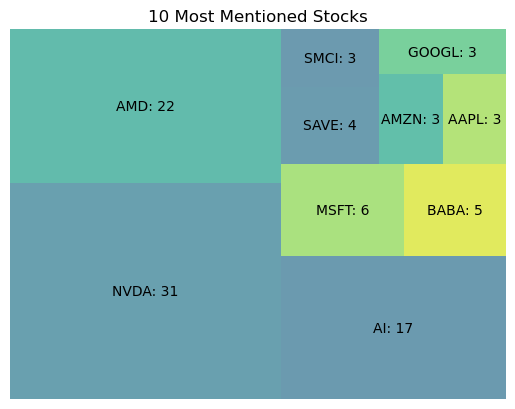

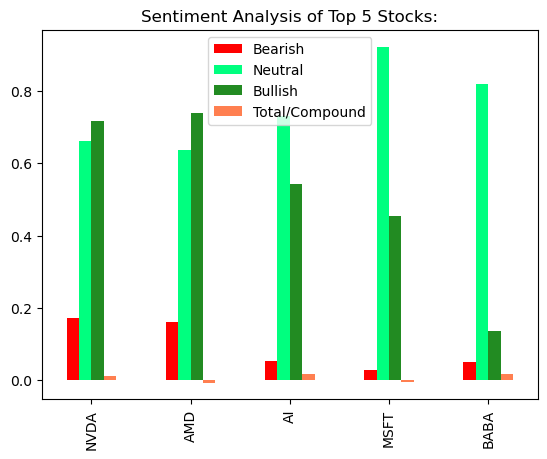

In [31]:
Based on original author: github:asad70
    

def data_extractor(reddit):

    # set the program parameters
    subs = ['StockMarket', 'stocks', 'wallstreetbets']     # sub-reddit to search
    post_flairs = {'Daily Discussion', 'Weekend Discussion', 'Discussion'}    # posts flairs to search || None flair is automatically considered
    goodAuth = {'AutoModerator'}   # authors whom comments are allowed more than once
    uniqueCmt = True                # allow one comment per author per symbol
    ignoreAuthP = {'can be filled if required'}       # authors to ignore for posts 
    ignoreAuthC = {'can be filled if required'}       # authors to ignore for comment 
    upvoteRatio = 0.70         # upvote ratio for post to be considered, 0.70 = 70%
    ups = 20       # define # of upvotes, post is considered if upvotes exceed this #
    limit = 1     # define the limit, comments 'replace more' limit
    upvotes = 2     # define # of upvotes, comment is considered if upvotes exceed this #
    picks = 10     # define # of picks here, prints as "Top ## picks are:"
    picks_ayz = 5   # define # of picks for sentiment analysis    
    
    posts, count, c_analyzed, tickers, titles, a_comments = 0, 0, 0, {}, [], {}
    cmt_auth = {}
    
    for sub in subs:
        subreddit = reddit.subreddit(sub)
        hot_python = subreddit.hot()    # sorting posts by hot
        # Extracting comments, symbols from subreddit
        for submission in hot_python:
            flair = submission.link_flair_text 
            # Check if the author is not None
            if submission.author is not None:
                author = submission.author.name
                # ... [rest of your loop's code] ...
            else:
                continue  # Skip this submission if the author is None        
            
            # checking: post upvote ratio # of upvotes, post flair, and author 
            if submission.upvote_ratio >= upvoteRatio and submission.ups > ups and (flair in post_flairs or flair is None) and author not in ignoreAuthP:   
                submission.comment_sort = 'new'     
                comments = submission.comments
                titles.append(submission.title)
                posts += 1
                try: 
                    submission.comments.replace_more(limit=limit)   
                    for comment in comments:
                        # try except for deleted account?
                        try: auth = comment.author.name
                        except: pass
                        c_analyzed += 1
                        
                        # checking: comment upvotes and author
                        if comment.score > upvotes and auth not in ignoreAuthC:      
                            split = comment.body.split(" ")
                            for word in split:
                                word = word.replace("$", "")        
                                # upper = ticker, length of ticker <= 5, excluded words,                     
                                if word.isupper() and len(word) <= 5 and word not in blacklist and word in us:
                                    
                                    # unique comments, try/except for key errors
                                    if uniqueCmt and auth not in goodAuth:
                                        try: 
                                            if auth in cmt_auth[word]: break
                                        except: pass
                                        
                                    # counting tickers
                                    if word in tickers:
                                        tickers[word] += 1
                                        a_comments[word].append(comment.body)
                                        cmt_auth[word].append(auth)
                                        count += 1
                                    else:                               
                                        tickers[word] = 1
                                        cmt_auth[word] = [auth]
                                        a_comments[word] = [comment.body]
                                        count += 1   
                except Exception as e: print(e)
                
                           
    return posts, c_analyzed, tickers, titles, a_comments, picks, subs, picks_ayz


def print_helper(tickers, picks, c_analyzed, posts, subs, titles, time, start_time):

    # sorts the dictionary
    symbols = dict(sorted(tickers.items(), key=lambda item: item[1], reverse = True))
    top_picks = list(symbols.keys())[0:picks]
    time = (time.time() - start_time)
    
    # print top picks
    print("It took {t:.2f} seconds to analyze {c} comments in {p} posts in {s} subreddits.\n".format(t=time, c=c_analyzed, p=posts, s=len(subs)))
    print("Posts analyzed saved in titles")
    #for i in titles: print(i)  # prints the title of the posts analyzed
    
    
    print(f"\n{picks} most mentioned tickers: ")
    times = []
    top = []
    for i in top_picks:
        print(f"{i}: {symbols[i]}")
        times.append(symbols[i])
        top.append(f"{i}: {symbols[i]}")
   
    return symbols, times, top
    
    
def sentiment_analysis(picks_ayz, a_comments, symbols):

    scores = {}
     
    vader = SentimentIntensityAnalyzer()
    vader.lexicon.update(new_words)     # adding custom words from data.py 
    picks_sentiment = list(symbols.keys())[0:picks_ayz]
    
    for symbol in picks_sentiment:
        stock_comments = a_comments[symbol]
        for cmnt in stock_comments:
    
            # Remove emojis and emoticons
            emojiless = re.sub(r'[^\w\s,]', '', cmnt)  # Basic emoji removal
            emojiless = re.sub('[\U0001F600-\U0001F64F]', '', emojiless)  # Basic emoticons
            emojiless = re.sub('[\U0001F300-\U0001F5FF]', '', emojiless)  # Symbols & Pictographs
            emojiless = re.sub('[\U0001F680-\U0001F6FF]', '', emojiless)  # Transport & Map Symbols
            emojiless = re.sub('[\U0001F1E0-\U0001F1FF]', '', emojiless)  # Flags (iOS)
            emojiless = re.sub('[\U00002702-\U000027B0]', '', emojiless)  # Additional emoticons
            emojiless = re.sub('[\U000024C2-\U0001F251]', '', emojiless)  # Additional symbols
            
            # remove punctuation
            text_punc  = "".join([char for char in emojiless if char not in string.punctuation])
            text_punc = re.sub('[0-9]+', '', text_punc)
                
            # tokenizeing and cleaning 
            tokenizer = RegexpTokenizer('\w+|\$[\d\.]+|http\S+')
            tokenized_string = tokenizer.tokenize(text_punc)
            lower_tokenized = [word.lower() for word in tokenized_string] # convert to lower case
            
            # remove stop words
            nlp = en_core_web_sm.load()
            stopwords = nlp.Defaults.stop_words
            sw_removed = [word for word in lower_tokenized if not word in stopwords]
            
            # normalize the words using lematization
            lemmatizer = WordNetLemmatizer()
            lemmatized_tokens = ([lemmatizer.lemmatize(w) for w in sw_removed])
            
            # calculating sentiment of every word in comments n combining them
            score_cmnt = {'neg': 0.0, 'neu': 0.0, 'pos': 0.0, 'compound': 0.0}
            
            word_count = 0
            for word in lemmatized_tokens:
                if word.upper() not in us:
                    score = vader.polarity_scores(word)
                    word_count += 1
                    for key, _ in score.items():
                        score_cmnt[key] += score[key]    
                else:
                    score_cmnt['pos'] = 2.0               
                    
            # calculating avg.
            try:        # handles: ZeroDivisionError: float division by zero
                for key in score_cmnt:
                    score_cmnt[key] = score_cmnt[key] / word_count
            except: pass
                
            
            # adding score the the specific symbol
            if symbol in scores:
                for key, _ in score_cmnt.items():
                    scores[symbol][key] += score_cmnt[key]
            else:
                scores[symbol] = score_cmnt        
    
        # calculating avg.
        for key in score_cmnt:
            scores[symbol][key] = scores[symbol][key] / symbols[symbol]
            scores[symbol][key]  = "{pol:.3f}".format(pol=scores[symbol][key])
            
    return scores


def visualization(picks_ayz, scores, picks, times, top):

    # printing sentiment analysis 
    print(f"\nSentiment analysis of top {picks_ayz} picks:")
    df = pd.DataFrame(scores)
    df.index = ['Bearish', 'Neutral', 'Bullish', 'Total/Compound']
    df = df.T
    print(df)
    
    # Date Visualization
    # most mentioned picks    
    squarify.plot(sizes=times, label=top, alpha=.7 )
    plt.axis('off')
    plt.title(f"{picks} Most Mentioned Stocks")
    plt.show()
    
    # Sentiment analysis
    df = df.astype(float)
    colors = ['red', 'springgreen', 'forestgreen', 'coral']
    df.plot(kind = 'bar', color=colors, title=f"Sentiment Analysis of Top {picks_ayz} Stocks:")
    
    
    plt.show()

def main(reddit):

    start_time = time.time()

    # Rest of your script's logic
    posts, c_analyzed, tickers, titles, a_comments, picks, subs, picks_ayz = data_extractor(reddit)
    symbols, times, top = print_helper(tickers, picks, c_analyzed, posts, subs, titles, time, start_time)
    scores = sentiment_analysis(picks_ayz, a_comments, symbols)
    visualization(picks_ayz, scores, picks, times, top)

# Execute main function with the authenticated reddit instance
if __name__ == '__main__':
    main(reddit)

### Analysis only the new post_flair

It took 30.33 seconds to analyze 902 comments in 24 posts in 3 subreddits.

Posts analyzed saved in titles

10 most mentioned tickers: 
NVDA: 14
AMD: 12
AI: 8
BABA: 6
MSFT: 5
AMZN: 4
SMCI: 3
TSLA: 3
GOOGL: 3
MELI: 3

Sentiment analysis of top 10 picks:
        Bearish   Neutral   Bullish  Total/Compound
NVDA   0.085571  0.703143  0.211143        0.429893
AMD    0.121417  0.610250  0.268333        0.325442
AI     0.111500  0.715750  0.172750        0.297463
BABA   0.180000  0.683333  0.136667        0.399533
MSFT   0.053800  0.874600  0.071600        0.172120
AMZN   0.064000  0.647500  0.289000        0.395550
SMCI   0.055000  0.892333  0.052667       -0.017200
TSLA   0.038333  0.667000  0.294667        0.390533
GOOGL  0.000000  0.802667  0.197333        0.146800
MELI   0.058667  0.724667  0.216000        0.764400


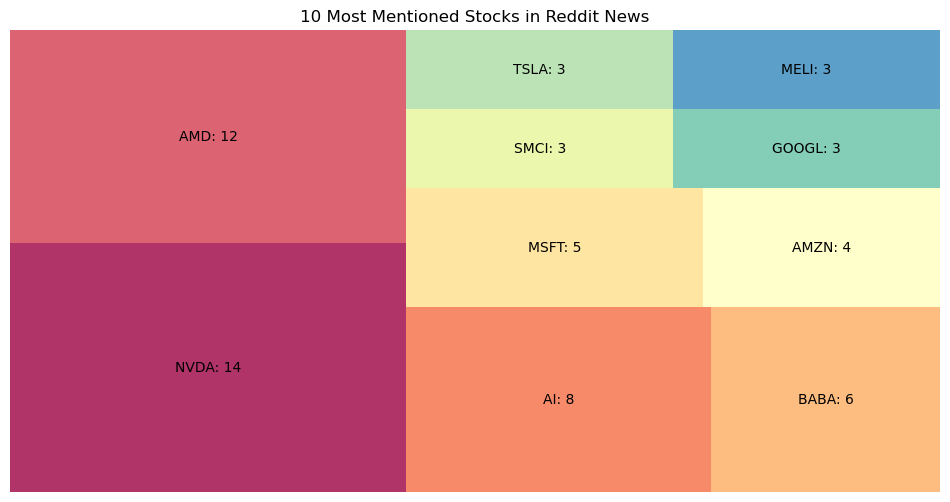

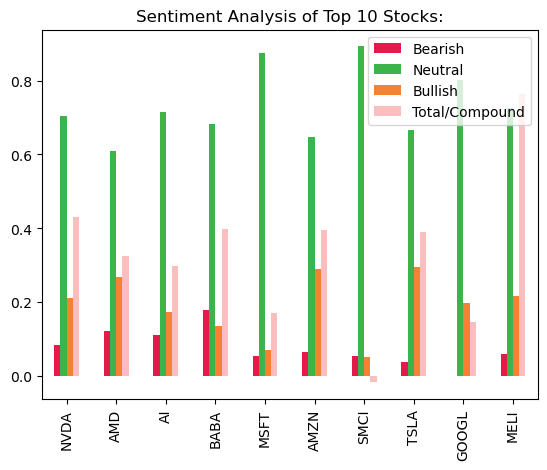

In [30]:
# Parameters
subs = ['StockMarket', 'stocks', 'wallstreetbets']
post_flairs = {'news'}
goodAuth = {'AutoModerator'}
uniqueCmt = True
ignoreAuthP = {'can be filled if required'}
ignoreAuthC = {'can be filled if required'}
upvoteRatio = 0.70
ups = 20
limit = 1
upvotes = 2
picks = 10
picks_ayz = 5

# Initialize VADER sentiment analyzer
vader = SentimentIntensityAnalyzer()

def data_extractor(reddit):
    posts, count, c_analyzed, tickers, titles, a_comments = 0, 0, 0, {}, [], {}
    cmt_auth = {}

    for sub in subs:
        subreddit = reddit.subreddit(sub)
        hot_python = subreddit.hot()
        for submission in hot_python:
            flair = submission.link_flair_text
            if submission.author is not None:
                author = submission.author.name
            else:
                continue
            
            if submission.upvote_ratio >= upvoteRatio and submission.ups > ups and (flair in post_flairs or flair is None) and author not in ignoreAuthP:
                submission.comment_sort = 'new'
                comments = submission.comments
                titles.append(submission.title)
                posts += 1
                try:
                    submission.comments.replace_more(limit=limit)
                    for comment in comments:
                        try:
                            auth = comment.author.name
                        except:
                            pass
                        c_analyzed += 1
                        
                        if comment.score > upvotes and auth not in ignoreAuthC:
                            split = comment.body.split(" ")
                            for word in split:
                                word = word.replace("$", "")
                                if word.isupper() and len(word) <= 5 and word not in blacklist and word in us:
                                    if uniqueCmt and auth not in goodAuth:
                                        try:
                                            if auth in cmt_auth[word]:
                                                break
                                        except:
                                            pass
                                    if word in tickers:
                                        tickers[word] += 1
                                        a_comments[word].append(comment.body)
                                        cmt_auth[word].append(auth)
                                        count += 1
                                    else:
                                        tickers[word] = 1
                                        cmt_auth[word] = [auth]
                                        a_comments[word] = [comment.body]
                                        count += 1
                except Exception as e:
                    print(e)

    return posts, c_analyzed, tickers, titles, a_comments, picks, subs, picks_ayz

def print_helper(tickers, picks, c_analyzed, posts, subs, titles, time, start_time):
    symbols = dict(sorted(tickers.items(), key=lambda item: item[1], reverse = True))
    top_picks = list(symbols.keys())[0:picks]
    time = (time.time() - start_time)

    print("It took {:.2f} seconds to analyze {} comments in {} posts in {} subreddits.\n".format(time, c_analyzed, posts, len(subs)))
    print("Posts analyzed saved in titles")
    
    print("\n{} most mentioned tickers: ".format(picks))
    times = []
    top = []
    for i in top_picks:
        print("{}: {}".format(i, symbols[i]))
        times.append(symbols[i])
        top.append("{}: {}".format(i, symbols[i]))

    return symbols, times, top

def sentiment_analysis(picks_ayz, a_comments, symbols):
    scores = {}
    
    # Use the global 'vader' object initialized earlier
    global vader

    picks_sentiment = list(symbols.keys())[0:picks_ayz]
    for symbol in picks_sentiment:
        stock_comments = a_comments[symbol]
        symbol_scores = {'neg': 0, 'neu': 0, 'pos': 0, 'compound': 0}

        for cmnt in stock_comments:
            # Remove emojis and special characters
            cmnt = re.sub(r'[^\w\s]', '', cmnt)

            # Tokenization and lower casing
            tokenizer = RegexpTokenizer(r'\w+')
            tokenized_text = tokenizer.tokenize(cmnt.lower())

            # Load Spacy model for stopwords and lemmatization
            nlp = en_core_web_sm.load()
            stopwords_list = nlp.Defaults.stop_words

            # Remove stopwords and perform lemmatization
            lemmatizer = WordNetLemmatizer()
            lemmatized_text = [lemmatizer.lemmatize(word) for word in tokenized_text if word not in stopwords_list]

            # Join the tokens back into a string
            cleaned_text = ' '.join(lemmatized_text)

            # Sentiment calculation
            sentiment_score = vader.polarity_scores(cleaned_text)
            for key in symbol_scores:
                symbol_scores[key] += sentiment_score[key]

        # Average the sentiment scores for each symbol
        num_comments = len(stock_comments)
        if num_comments > 0:
            for key in symbol_scores:
                scores[symbol] = {k: v / num_comments for k, v in symbol_scores.items()}

    return scores

def visualization(picks_ayz, scores, picks, times, top):
    print("\nSentiment analysis of top {} picks:".format(picks_ayz))
    df = pd.DataFrame(scores).head(10)  # Limit to top 10
    df.index = ['Bearish', 'Neutral', 'Bullish', 'Total/Compound']
    df = df.T
    print(df)

    # Adjusted Treemap with non-duplicated mention counts
    plt.figure(figsize=(12, 6))
    colors = [plt.cm.Spectral(i/float(len(times[:10]))) for i in range(len(times[:10]))]
    squarify.plot(sizes=times[:10],label=top, alpha=0.8, color=colors)
    plt.title("{} Most Mentioned Stocks in Reddit News".format(picks))
    plt.axis('off')
    plt.show()

    # Bar Chart for Sentiment Analysis
    df = df.astype(float)
    colors = ['#e6194B', '#3cb44b', '#f58231', '#fabebe']
    df.plot(kind='bar', color=colors, title="Sentiment Analysis of Top {} Stocks:".format(picks_ayz))
    plt.show()
    
#def extract_key_sentences(a_comments, scores, top_picks):
#    key_sentences = {}
#    for symbol in top_picks:
#        highest_score = 0
#        key_sentence = ""
#        for comment in a_comments[symbol]:
#            sentiment_score = vader.polarity_scores(comment)
#            total_score = sentiment_score['compound']
#            if abs(total_score) > abs(highest_score):
#               highest_score = total_score
#                key_sentence = comment
#        key_sentences[symbol] = key_sentence
#    return key_sentences

def main(reddit):
    start_time = time.time()
    posts, c_analyzed, tickers, titles, a_comments, picks, subs, picks_ayz = data_extractor(reddit)
    symbols, times, top = print_helper(tickers, picks, c_analyzed, posts, subs, titles, time, start_time)
    scores = sentiment_analysis(picks, a_comments, symbols)
    #key_sentences = extract_key_sentences(a_comments, scores, list(symbols.keys())[:10])
    visualization(picks, scores, picks, times, top)
  

    #print("\nKey Sentences for Top Picks:")
    #for symbol, sentence in key_sentences.items():
    #    print(f"{symbol}: {sentence}")

if __name__ == '__main__':
    
    main(reddit)